<h1 style="text-align: center;">ST455 FINAL PROJECT</h1>

## Package Requirement List

In [1]:
# data processing requirements
import pandas as pd
import numpy as np
import itertools
import pickle

# visualization requirements
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Image
import seaborn as sns

# system requirements
import random
import copy
from math import comb

# DQN requirements
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
from sklearn.neural_network import MLPRegressor

# modules in .py scripts
from agents import RandomAgent, GreedyAgent1, DQNAgent_online, DQNAgent_offline
from experiments import greedy1, get_best_schedule, online_dqn, offline_dqn
from environment import Job, Machine, State, SchedulingEnvironment, standardise_vector
from tools import generate_random_jobs, generate_random_machines

/Users/emilialautz/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Abstract

I explore the application of reinforcement learning (RL) techniques to solve the Parallel Machine Scheduling Problem (PMS), which is an optimisation task that has been classified as NP-hard (Mokotoff, 2001, p. 194). The PMS requires allocating a set number of jobs (*n*) to multiple machines (*m*) to minimise, for example, the priority-weigted cycle time (PWCT). Given the computational complexity and the lack of existing optimal solutions for larger instances, researchers have most commonly used heuristics to approximate optimal solutions (e.g., Kayvandar, Komaki, Aalaei & Zandieh, 2014). We follow the research conducted by Lee, Kang, Lee, Lee, & Kim (2023) and Paeng, Park & Park (2021), who deploy Deep Q-Networks (DQNs) to approximate optimal machine schedules. More precisely, we explore an online DQN agent and an offline DQN agent, in which we implement a fitted Q iteration (FQI). These were benchmarked against a standard greedy agent to evaluate performance. Our findings indicate that while the online DQN agent did not minimise the PWCT compared to the greedy agent, the offline DQN agent demonstrated a superior performance, consistently yielding lower PWCT across five different datasets comprising 10, 20, 30, 40, and 50 jobs. This study underscores the potential of RL approaches in efficiently handling complex scheduling tasks. However, due to the limited computing power on our private machines, we suggest further research regarding the architecture of the neural networks we employed as well as testing the agents on much larger datasets.

## Introduction

### The Parallel Machine Scheduling Problem

In the most common representation of the Parallel Machine Scheduling Problem (PMS), there are *n* jobs and *m* machines (Mokotoff, 2001, p. 193). Each job can be processed by different machines in fixed processing times and the aim is to find a schedule that optimises certain performance measures (Mokotoff, 2001, p. 193). The PMS differs from single machine problems, as one not merely aims to find the optimal job sequencing (i.e., the order in which the jobs are processed), but it is further necessary to find an optimal job-machine assignment if *m* > 1 (Mokotoff, 2001, p. 193). The complexity of PMS problems increases exponentially in the number of machines and jobs, challenging researchers to find algorithms that detect optimal solutions (Mokotoff, 2001, p. 193).

In the past decades, PMS problems have been increasingly researched for several reasons. Firstly, PMS problems are relevant for large-scale industrial manufacturing, as optimising scheduling tasks is essential for enhancing productivity and efficiency (Lee, Kang, Lee, Lee, & Kim, 2023, p. 1). Additionally, environmental concerns have motivated researchers such as Li, Yang, Zhang & Liu (2016) to approximate optimal solutions to the PMS. The enormeous consumption of energy by the industrial sector poses questions as to how energy consumption in manufacturing systems can be reduced, for instance by optimising the production schedules (Li, Yang, Zhang & Liu, 2016).

However, most scheduling problems are not solvable in polynomial time, classifying the PMS as NP-hard (Mokotoff, 2001, p. 194). Commonly, metaheuristics and rule-based methods have been used to solve PMS problems (e.g., Kayvandar, Komaki, Aalaei & Zandieh (2014), Li, Yang, Zhang & Liu (2016)). However, as these methods make decisions in a myopic manner, Paeng, Park & Park (2021) propose to utilise deep reinforcement learning (DRL) as to minimise total tardiness. They find that the DRL agents successfully outperforms metaheuristics, rule-based methods as well as other RL-based approaches in terms of reducing total tardiness (Paeng, Park & Park, 2021). For this assignment, we losely follow the approaches suggested by Paeng, Park & Park (2021) and Lee, Kang, Lee, Lee, & Kim (2023) in modelling and solving the PMS problem with DRL.


### Chosen variation of the PMS problem

Researchers have investigated many variations of the PMS, for instance with the objective of minimising total completion time (e.g., Yang & Yang, 2013) or total tardiness (e.g., Kayvandar, Komaki, Aalaei & Zandieh, 2014). As we introduced a priority variable for each job, which denotes the importance of processing the job early on, we chose to minimise a slightly different version of the completion time, namely the priority weighted cycle time (PWCT). The PWCT sums up the product of each job’s priority and its completion time on the machine it has been assigned to for all jobs. The objective can thereby be formalised as:

$$ \min \LARGE ( \normalsize \text{PWCT} \LARGE) \normalsize = \min \LARGE ( \normalsize \sum_{i=1}^{N_J} (p_i * d_i) \LARGE) \normalsize $$

with $p_i$ being the priority for job $i$, $d_i$ being the end time for job $i$ and $N_J$ being the number of jobs in the PMS.

Similarly to Paeng, Park & Park (2021), we introduced a family setup, according to which each job is associated with one of four job families. Each machine is capable of completing jobs of one to four out of the available families. Following Kayvandar, Komaki, Aalaei & Zandieh (2014), the job families are associated with varying processing times depending on the machine. For instance, machine 1 could be capable of processing jobs of family 1 in 30 minutes and jobs of family 4 in 90 minutes. And machine 2 might only be capable of processing jobs of family 4 in 60 minutes.

Partially based on Motokoff (2021, p. 197), we make the following assumptions:

1. Each job is processed in a single operation that cannot be executed on more than one machine simultaneously.

2. Ready times are zero for all jobs (i.e., there are no delays: once a job is allocated to a machine, it is processed instantly).

3. Jobs of family i can only be allocated to machines that can process family i.

4. There is no cancellation of jobs or switching machines during processing. Once a job is allocated to a machine, it has to be completed on that machine.

5. Each machine can process no more than one job at a time.

6. The number of jobs, machines and families as well as the processing times are known and fixed. 

## Methodology

### MDP formulation

In order to employ RL methods, we formulate the PMS as a Markov Decision Process (MDP). According to Sutton & Barto (2014), MDPs are "a classical formalization of sequential decision making, where actions influence not just immediate rewards, but also subsequent situations, or states, and through those future rewards" (p. 47). Following the notation in Sutton & Barto (2014), we denote the set of all nonterminal states and the set of all possible rewards as $\mathcal{S}$ and $\mathcal{R}$, respectively. The set of all actions available in state $s$ is noted as $\mathcal{A(s)}$. The state, action and reward at timestep $t$ are formalised as $s_t$, $a_t$, and $r_t$, respectively. At each timestep $t$, the agent receives a representation of the current state $s_t$ and on that basis selects an action $a_t \in \mathcal{A(s_t)}$. Following this action, the agent receives a numerical reward $r_{t+1}$ and finds itself in a new state $s_{t+1}$. This interaction between the agent and the environment is visualised in figure 1.

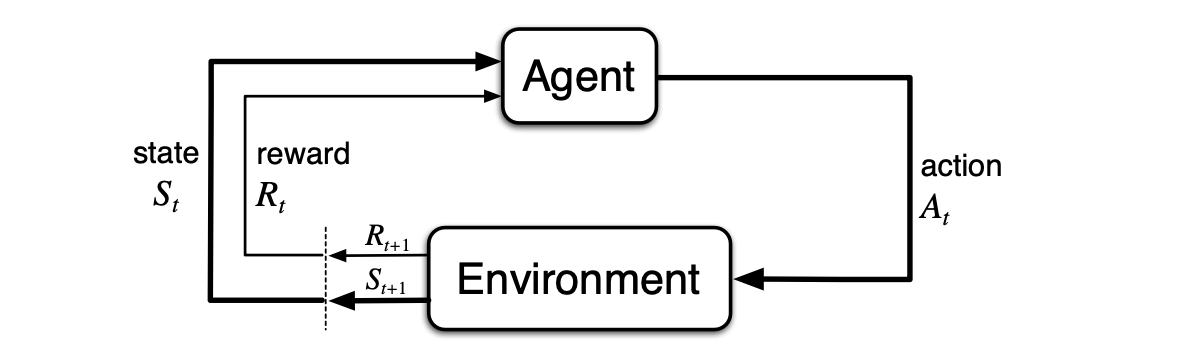

**Figure 1**: Agent-environment interaction in a Markov Decision Process (Sutton & Barto, 2014, p. 48)

In the following, we define the state, action and reward in our modelled version of the PMS in more detail.

#### State

The state is represented by three state features - two vectors and one matrix - as seen in table 1. The code defining the State class and it's methods can be found in the script 'environment.py'. We first define the following notations to describe the three state features:

- $N_J$ - number of jobs
- $N_M$ - number of machines (fixed to 5)
- $N_F$ - number of families (fixed to 4)

| Notation | Feature | Description | Dimension |
|---------|---------|---------|---------|
| $S_J$ | Jobs per family | How many jobs of each job family have not yet been allocated. | $ N_F$ |
| $S_B$ | Machine busyness | How many jobs of each job family have been allocated to each machine. | $N_M \times N_F $ |
| $S_P$ | Priority weighted processing time | Sum of the priority weighted processing times (i.e., the product of priority and processing time) for all jobs allocated to each machine. | $ N_M $ |

**Table 1**: State features 

Specifically, the feature $S_J$ represents how many jobs have not yet been allocated for each job family. It is defined as a vector of length $ N_F$ and initialised with the number of jobs per family that the problem has at the start of an episode. Next, the schedule of each machine is represented by the matrix $S_B$. This feature indicates, how many jobs have been allocated to each machine for each job family. It is initialised as a matrix of dimension $N_M \times N_F $ with all entries being set to zero. Finally, we include a vector $S_P$ displaying the priority weighted processing time, which is calculated when a job is allocated to a machine. More precisely, the priority weighted processing time for job $j_i$ is the product of its priority and the processing time it has on the machine that $j_i$ has been allocated to. This vector has the length $ N_M $ and all entries are initialised to zero. With this definition of the state, the current state captures all relevant information from history. Thereby, the state has the Markov property, according to which it must include "information about all aspects of the past agent–environment interaction that make a difference for the future" (Sutton & Barto, 2014, p. 49).

#### Action

An action $a_t$ is defined as a job $j_i$ being allocated to a machine $m_k$ and is represented as the tuple ($j_i$, $m_k$). Note that only job-machine pairings that share the same family can make up an action (assumption 3).

#### Reward

The reward of job $j_i$ has been defined as the product of the priority of $j_i$ and its end time on the machine it has been assigned to. The objective is to minimise the total reward, which is the PWCT as elaborated above. Hence, an action yielding a lower reward should be preferred.

#### State transition following an action

After executing an action $a_t$, the state transitions from $s_t$ to $s_{t+1}$. The code for this is defined in the step function of our SchedulingEnvironment class, which can be found in the 'environment.py' script. In the three figures below, it is elaborated how a state transition affects the three state features individually. 

In this example, we set $N_J = 10$, $N_M = 5$ and $N_F = 4$. Let $J_i \in J \text{ for } i = 1, 2, \ldots, 10$ denote the jobs, $M_i \in M \text{ for } i = 1, 2, \ldots, 5$ denote the machines and $F_i \in F \text{ for } i = 1, 2, 3, 4$ denote the job families. Figures 2-4 show how random actions change the state features in two transitions.



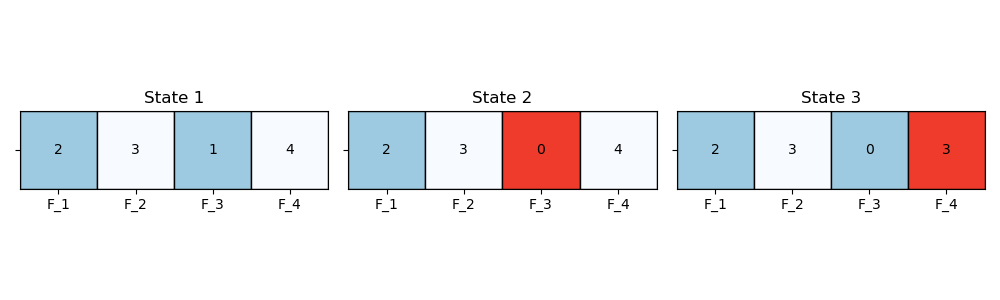

In [18]:
# Display the jobs per family vector
image_path = 'plots/jobs_per_family.png'
display(Image(filename=image_path))

**Figure 2**: State feature $S_J$ with two transitions.

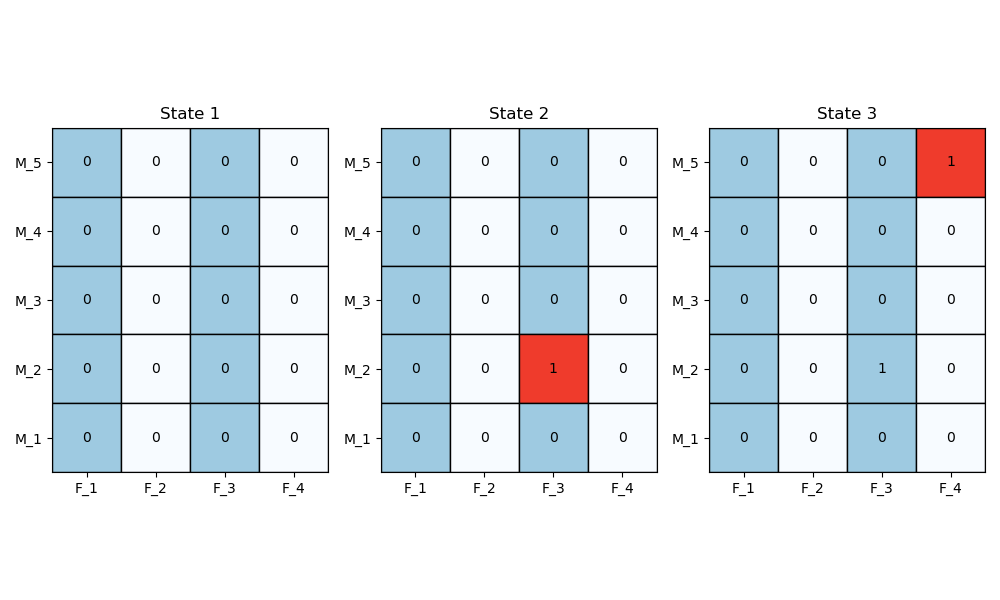

In [19]:
# Display the machine busyness matrix
image_path = 'plots/machine_busyness.png'
display(Image(filename=image_path))

**Figure 3**: State feature $S_B$ with two transitions.

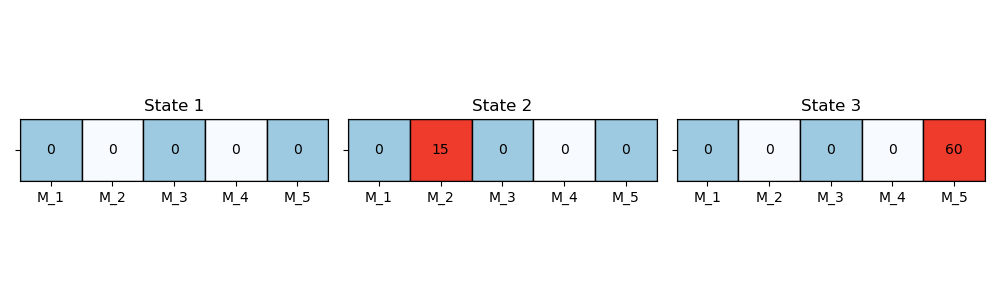

In [20]:
# Display the priority weighted processing time matrix
image_path = 'plots/priority_processing_time.png'
display(Image(filename=image_path))

**Figure 4**: State feature $S_P$ with two transitions.

**State 1**:
In the first state, $s_1$, no jobs have been allocated yet. Thus, all 10 jobs appear in the feature $S_J$. As we can see, we initially have 2 jobs of family $F_1$, three jobs of family $F_2$, 1 job of family $F_3$, and 4 jobs of family $F_4$. As seen in the feature $S_B$, all machine schedules are empty because no jobs have yet been allocated. For the same reason, the feature $S_P$ is also initialised at 0 for all machines.

Now, the action $a_1 = (J_4, M_2)$ is taken, according to which job $J_4$ of family $F_3$ is allocated to machine $M_2$ and we transition to state $s_2$.

**State 2**:
One job of family $F_3$ is now removed from the feature $S_J$, thus leaving this family as empty. The feature $S_B$ is updated for machine $M_2$ at the position of $F_3$, which is represented by adding 1. Lastly, the priority weighted processing time of $M_2$, which is 15 in this example, was added to the feature $S_P$ at the position representing machine $M_2$.

Now, the action $a_2 = (J_7, M_5)$ is taken, according to which job $J_7$ of family $F_4$ is allocated to machine $M_5$ and we transition to state $s_3$.

**State 3**:
One job of family $F_4$ is now removed from the feature $S_J$. Now, we have 3 jobs remaining in $S_J$ at the position of family $F_4$. The feature $S_B$ is updated for machine $M_5$ at the position of $F_4$, which is represented by adding 1. Lastly, the priority weighted processing time of $M_5$, which is 60 in this example, was added to the feature $S_P$ at the position representing machine $M_5$.

With this definition of states, actions, rewards and transitions, the formalisation of the PMS aligns with the definition of a Markov chain, according to which an action $a_t$ only impacts the state that follows this action $s_{t+1}$, as seen in figure 5.

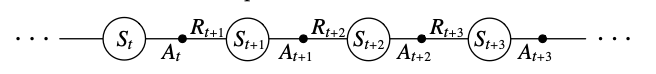

**Figure 5**: Markov chain for one episode (Sutton & Barto, 2014, p. 129)

### Data

In order to train and test models that solve the PMS, we require two sources of data: 

1. A set of jobs $J$ 
2. A set of machines $M$, with $N_M = 5$

As previously mentioned, we set the number of job families to $N_F = 4$, meaning that each $J_i \in J$ must be assigned to one of the four families $F_i \in F \text{ for } i = 1, 2, 3, 4$. Furthermore each job object has a priority attribute, which we randomly computed as either 1, 0.1 or 0.5. Each machine $M_i \in M \text{ for } i = 1, 2, \ldots, 5$ is also assigned to one to four families $F_i \in F \text{ for } i = 1, 2, 3, 4$. Furthermore, machine objects contain a dictionary attribute, which maps families to the machine specific processing times.

Jobs and machines were randomly created using two functions that can be found in the script 'tools.py'. To evaluate the performance of the models, we trained and ran them on five different datasets comprising 10, 20, 30, 40, and 50 jobs leaving $N_M$ and $N_F$ fixed for comparability. A summary of the data can be seen in table 2.

| Dataset no. | $N_J$ | $N_M$ | $N_F$ |
|---------|---------|---------|---------|
| 1 | 10 | 5 | 4 | 
| 2 | 20 | 5 | 4 | 
| 3 | 30 | 5 | 4 | 
| 4 | 40 | 5 | 4 | 
| 5 | 50 | 5 | 4 | 

**Table 2**: Datasets used in this assignment

## Models

Firstly, we develop a greedy algorithm to use as a baseline. Secondly, aligning with the approach proposed by Lee, Kang, Lee, Lee, & Kim (2023), we develop an online DQN agent. However, since this agent did not produce results surpassing the performance of greedy, we additionally developed a third model, an offline DQN agent. The definition of the agent classes can be found in the script 'agents.py'.

### Greedy Algorithm

The greedy algorithm iterates through the available actions and selects the one with the minimum priority processing time, i.e., the tuple ($j_i$, $m_k$), for which the product of $j_i$’s priority and $j_i$’s processing time on machine $m_k$ is minimised.

### Online DQN Agent

The framework for the online DQN agent follows a similar structure as presented by Lee, Kang, Lee, Lee, & Kim (2023), which can be found in figure 6. We differ from the framework in the use of a job selector. The paper uses a heuristic to select the next job to schedule, however, we allow the agent to pick the next job to schedule based on our state features and Q function approximator.

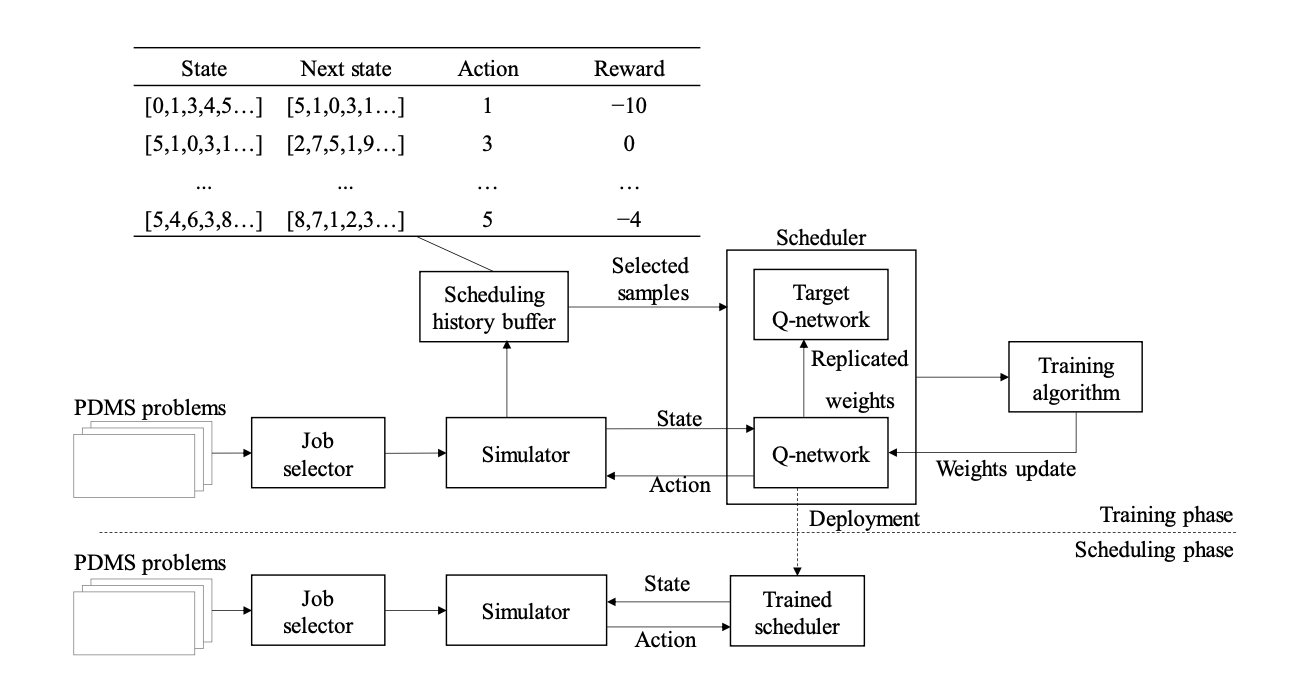

**Figure 6**: Framework of the DQN scheduler proposed by Lee, Kang, Lee, Lee, & Kim (2023, p. 4)

We use two neural networks of similar dimensions for the algorithm. A target neural network is used to compute the TD-target. The policy neural network is continously updated through the episode based on the sample we take from the replay buffer. This is done to steady the TD- target and therefore improve the learning of the agent. The target neural network is updated with the policy network at the end of each episode. Every time we recieve a (state, action, reward, next_state, done) combination from the environment we store this in the replay buffer and randomly sample from the buffer to update the neural network. We finally use the policy network once the training is completed to generate the best schedule.

On experimenting with different neural network architechtures, we settled for three hidden layers. As proposed by Lee, Kang, Lee, Lee, & Kim (2023), the input is the state feature vector, which in our case is a concatenated vector of the three state features described in figures 2-4. The output value is the predicted Q-value for all possible actions. As the training performances may vary according to the hyper-parameter settings (Lee, Kang, Lee, Lee, & Kim, 2023, p. 6), we implemented a random search to find the hyper-parameters that yield the best performance on a small instance of 10 jobs. More precisely, we optimise the batch size, gamma, epsilon start size and epsilon end size. The random search can be found in the script 'optimisation_online.py' and the results are saved in the CSV file 'results_parameters_online.csv'. The hyper-parameters yielding the best reward are printed out below.



In [21]:
# Get the best parameters from the optimisation

# Online
df_online = pd.read_csv('results_parameters_online.csv')
best_row_online = df_online.loc[df_online['total_reward'].idxmin()]
best_batch_size_online = int(best_row_online['batch_size'])
best_gamma_online = float(best_row_online['gamma'])
best_epsilon_start_online = float(best_row_online['epsilon_start'])
best_epsilon_end_online = float(best_row_online['epsilon_end'])

print('Best parameters for online DQN:')
print('Batch size:', best_batch_size_online)
print('Gamma:', best_gamma_online)
print('Epsilon start:', best_epsilon_start_online)
print('Epsilon end:', best_epsilon_end_online)

Best parameters for online DQN:
Batch size: 64
Gamma: 0.95
Epsilon start: 1.0
Epsilon end: 0.01


### Offline DQN Agent

The second RL Agent we trained uses an offline reinforcement learning approach and Fitted Q Iteration (FQI), a batch learning method particularly suitable for environments where real-time interaction is not feasible (Sutton & Barto, 2014). We begin by creating a dataset using 100 iterations of the scheduling problem and random actions. Each row consists of features of the current state, the next state given the action played and the associated reward, a binary variable indicating whether the next state is terminal and all possible states that can be reached after another action is chosen.

With the dataset ready, the learning process begins with initialising a ZeroEstimator that predicts zero values for any inputs. At each iteration, a target value y for each state in the dataset is computed for all possible $a$ at $t+1$ using the following temporal difference (TD) target formula:

$$ target =  R_t + \gamma * \min (V(S_t)) $$

where $R_t$ is the reward, $\gamma$ is the discount factor and $V(S_t)$ is the value predicted by the estimator. The function to compute the target can be found in the script 'tools.py'. We use these values to train an MLPestimator - a feedforward artificial neural network - which seeks to approximate the optimal Q-function. Following the training in each iteration, the updated estimator is used to compute the next TD target value. Actions are chosen based on the estimator's predictions, with the best action being the one that leads to a state with the lowest value.

Furthermore, we use a random search that optimises the following hyper parameters of the offline agent: discount factor $\gamma$, maximum number of iterations in the MPLestimator, as well as the number of neurons in the first and last hidden layer of the MLPestimator. The random search can be found in the script 'optimisation_offline.py' and it's results are saved to a csv file called 'results_parameters_offline'. Below, the optimal parameters that were then used to execute the FQI iteration on our five data sets are printed out below.

In [5]:
# Offline
df_offline = pd.read_csv('results_parameters_offline.csv')
best_row_offline = df_offline.loc[df_offline['total_reward'].idxmin()]
best_discount_factor_offline = best_row_offline['discount_factor']
best_max_iterations_offline = best_row_offline['max_iterations']
best_first_hidden_layer_offline = best_row_offline['first_hidden_layer']
best_last_hidden_layer_offline = best_row_offline['last_hidden_layer']

print('Best parameters for offline DQN:')
print('Discount factor:', best_discount_factor_offline)
print('Maximum number of iterations:', best_max_iterations_offline)
print('Neurons in the first hidden layer:', best_first_hidden_layer_offline)
print('Neurons in the last hidden layer:', best_last_hidden_layer_offline)

Best parameters for offline DQN:
Discount factor: 0.9
Maximum number of iterations: 500.0
Neurons in the first hidden layer: 512.0
Neurons in the last hidden layer: 32.0


## Experiments

The first experiment we run is on data set no. 1, which has 10 jobs. We execute the greedy algorithm as well the two DQN algorithms. The results can be seen below.

### Greedy - 10 Jobs

In [22]:
# Greedy agent 10 jobs

random.seed(123)
job_list = generate_random_jobs(10, 4)
machine_list = generate_random_machines(5, 4)

greedy_10_jobs = greedy1(job_list, machine_list, show_schedule = True)

Remaining jobs: []
Machines:
Machine 1: [6, 10, 5, 4]
Machine 2: [3]
Machine 3: []
Machine 4: [9, 7, 2]
Machine 5: [8, 1]
Jobs per family: [0 0 0 0]
Machine busyness: [2. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 0. 0. 2. 0.]
Priority processing time: [426.  12.   0. 540. 288.]
Priority Weighted Cycle Time (PWCT):  873.0


### Online DQN - 10 jobs

<Figure size 640x480 with 0 Axes>

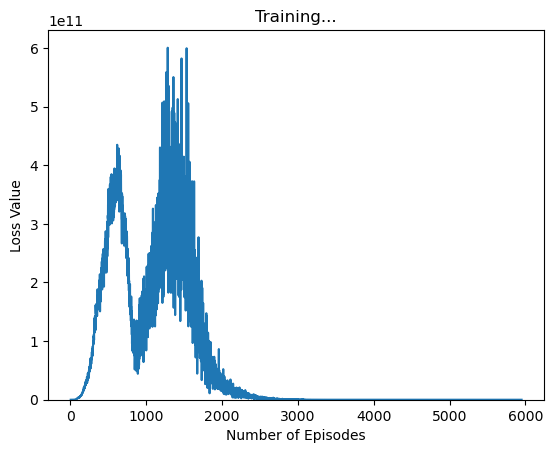

Episode 5951: Model loss = 683.5332641601562
Remaining jobs: []
Machines:
Machine 1: [5, 4, 2]
Machine 2: [6]
Machine 3: [10]
Machine 4: [3, 9, 7]
Machine 5: [8, 1]
Jobs per family: [0 0 0 0]
Machine busyness: [0. 0. 1. 2. 1. 0. 0. 0. 1. 0. 0. 0. 1. 2. 0. 0. 0. 0. 2. 0.]
Priority processing time: [420.  12. 240. 444. 288.]
None
Priority Weighted Cycle Time(PWCT) : 972.0


In [23]:
# Online DQN 10 jobs

random.seed(123)
job_list = generate_random_jobs(10, 4)
machine_list = generate_random_machines(5, 4)

online_10_jobs = online_dqn(job_list, machine_list, show_schedule = True)

### Offline DQN - 10 jobs

<Figure size 640x480 with 0 Axes>

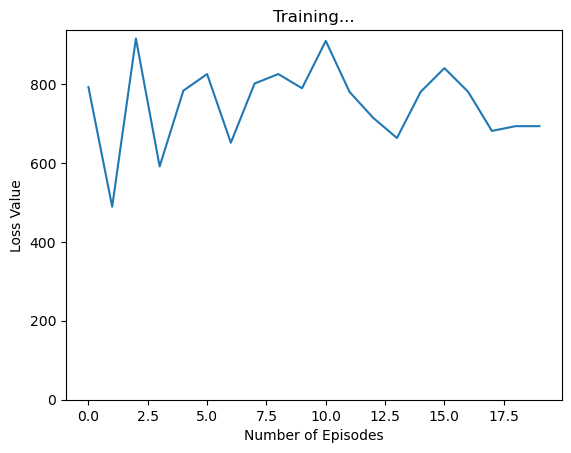

Remaining jobs: []
Machines:
Machine 1: [2, 4, 5]
Machine 2: [10]
Machine 3: [3, 6]
Machine 4: [7, 9]
Machine 5: [1, 8]
Jobs per family: [0 0 0 0]
Machine busyness: [0. 0. 1. 2. 1. 0. 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 0. 0. 2. 0.]
Priority processing time: [270. 120.  60. 210. 207.]
Priority Weighted Cycle Time (PWCT) DQNAgent_offline:  489.0


In [24]:
# Offline DQN 10 jobs

random.seed(123)
job_list = generate_random_jobs(10, 4)
machine_list = generate_random_machines(5, 4)

offline_10_jobs = offline_dqn(job_list, machine_list, show_schedule = True)

### Model comparison - 10 jobs

The performance of the three algorithms on dataset 1 can be seen in figure 7.

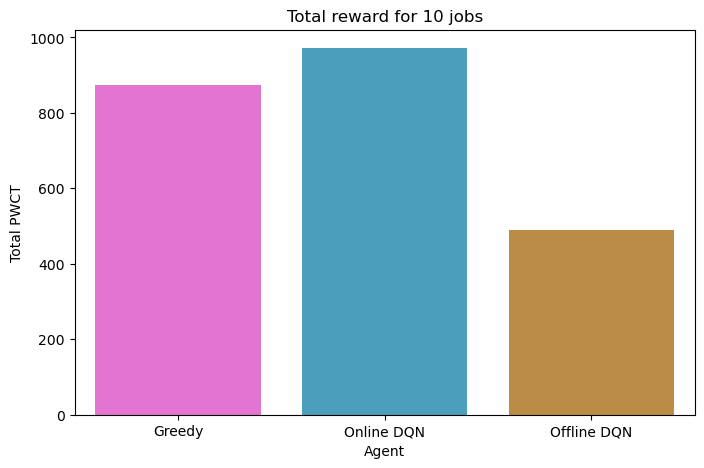

In [25]:
# Plot the results of the 10 job experiment

results_10_jobs = pd.DataFrame({'Agent': ['Greedy', 'Online DQN', 'Offline DQN'], 'Total PWCT': [greedy_10_jobs, online_10_jobs, offline_10_jobs]})

plt.figure(figsize=(8, 5))
sns.barplot(x='Agent', y='Total PWCT', data=results_10_jobs, palette={'Greedy': '#f561dd', 'Online DQN': '#39a7d0', 'Offline DQN': '#ce9032'})
plt.title('Total reward for 10 jobs')
plt.show()

**Figure 7**: Total reward for all agents on dataset 1 (10 jobs)

As seen in figure, 7, the optimised online DQN agent does not perform better than the greedy algorithm. However, the offline DQN approach yields a significantly lower total PWCT, implying that reinforcement learning can improve the approximation of the solution to the PMS problem compared to a simple heuristic on a data set with a small number of job instances. In order to test the robustness of this result, we will run the three models on the remaining four datasets.

### Further Experiments: Greedy

In [26]:
columns = ["Agent", "Jobs", "Machines", "Families", "Priority Weighted Cycle Time (PWCT)"]
results_greedy_df = pd.DataFrame(columns=columns)

job_tests = [10, 20, 30, 40, 50]

for jobs in job_tests:
    random.seed(123)
    job_list = generate_random_jobs(jobs, 4)
    machine_list = generate_random_machines(5, 4)

    try:
        greedy1(job_list, machine_list)
    except:
        continue

    results_greedy_df.loc[len(results_greedy_df)] = ['Greedy', jobs, 5, 4, greedy1(job_list, machine_list)]

print(results_greedy_df)    

    Agent  Jobs  Machines  Families  Priority Weighted Cycle Time (PWCT)
0  Greedy    10         5         4                                873.0
1  Greedy    20         5         4                               2157.0
2  Greedy    30         5         4                               3819.0
3  Greedy    40         5         4                               6012.0
4  Greedy    50         5         4                              13590.0


### Further Experiments: Online DQN

<Figure size 640x480 with 0 Axes>

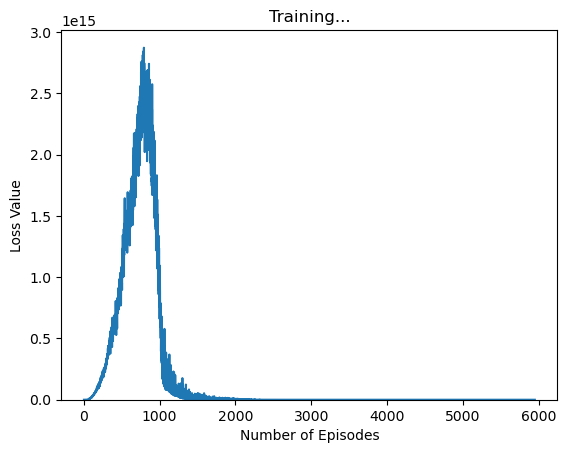

Episode 5951: Model loss = 239.12527465820312
Remaining jobs: []
Machines:
Machine 1: [27, 47, 31, 9, 29, 7, 16, 23, 32, 1, 45]
Machine 2: [3, 11, 41, 13, 10, 15]
Machine 3: [6, 37, 48, 50, 17]
Machine 4: [22, 26, 14, 20, 33, 44, 18, 19, 46, 12, 25, 24, 4, 2, 34, 40, 49]
Machine 5: [30, 28, 35, 8, 43, 38, 42, 5, 36, 21, 39]
Jobs per family: [0 0 0 0]
Machine busyness: [ 0.  5.  4.  2.  6.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0. 17.  2.  2.
  7.  0.]
Priority processing time: [5049. 1845. 2004. 3645. 4494.]
None
Priority Weighted Cycle Time(PWCT) : 14862.0
        Agent  Jobs  Machines  Families  Priority Weighted Cycle Time (PWCT)
0  Online DQN    10         5         4                                933.0
1  Online DQN    20         5         4                               2226.0
2  Online DQN    30         5         4                               5271.0
3  Online DQN    40         5         4                               7647.0
4  Online DQN    50         5         4              

In [27]:
columns = ["Agent", "Jobs", "Machines", "Families", "Priority Weighted Cycle Time (PWCT)"]
results_online_df = pd.DataFrame(columns=columns)

job_tests = [10, 20, 30, 40, 50]

for jobs in job_tests:
    print('Testing online DQN on', jobs, 'jobs')
    random.seed(123)
    job_list = generate_random_jobs(jobs, 4)
    machine_list = generate_random_machines(5, 4)

    try:
        greedy1(job_list, machine_list)
    except:
        continue

    results_online_df.loc[len(results_online_df.index)] = ['Online DQN', jobs, 5, 4, online_dqn(job_list, machine_list, show_schedule = True)]

print(results_online_df)

### Further Experiments: Offline DQN


<Figure size 640x480 with 0 Axes>

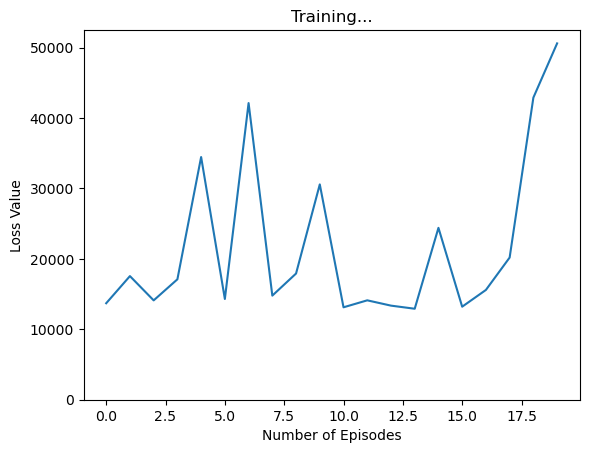

Remaining jobs: []
Machines:
Machine 1: [4, 7, 9, 16, 20, 23, 29, 32, 36, 38, 42, 45]
Machine 2: [3, 10, 11, 13, 15, 28, 30, 37, 41, 48, 50]
Machine 3: [6, 17]
Machine 4: [2, 12, 14, 18, 19, 22, 24, 25, 26, 27, 33, 34, 40, 44, 46, 47, 49]
Machine 5: [1, 5, 8, 21, 31, 35, 39, 43]
Jobs per family: [0 0 0 0]
Machine busyness: [ 0.  6.  4.  2. 11.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0. 17.  0.  1.
  7.  0.]
Priority processing time: [4875. 4662.  384. 2835. 2286.]
Priority Weighted Cycle Time (PWCT) DQNAgent_offline:  12921.0
         Agent  Jobs  Machines  Families  Priority Weighted Cycle Time (PWCT)
0  Offline DQN    10         5         4                                489.0
1  Offline DQN    20         5         4                               1419.0
2  Offline DQN    30         5         4                               3714.0
3  Offline DQN    40         5         4                               5007.0
4  Offline DQN    50         5         4                              12921.0


In [12]:
columns = ["Agent", "Jobs", "Machines", "Families", "Priority Weighted Cycle Time (PWCT)"]
results_offline_df = pd.DataFrame(columns=columns)

job_tests = [10, 20, 30, 40, 50]

for jobs in job_tests:
    print('Testing offline DQN on', jobs, 'jobs')
    random.seed(123)
    job_list = generate_random_jobs(jobs, 4)
    machine_list = generate_random_machines(5, 4)

    try:
        greedy1(job_list, machine_list)
    except:
        continue

    results_offline_df.loc[len(results_offline_df.index)] = ['Offline DQN', jobs, 5, 4, offline_dqn(job_list, machine_list, show_schedule = True)]

print(results_offline_df)

## Discussion of Results and Conclusion

The results of the conducted experiments are summarised in the table below.

In [28]:
# Merge the results into one dataframe
results_df = pd.concat([results_greedy_df, results_online_df, results_offline_df])

# Save the results as a csv file for future reference
results_df.to_csv('results.csv', index = False)

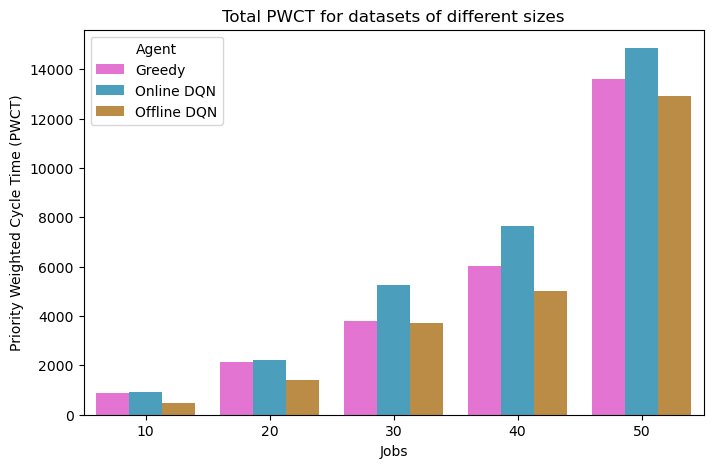

In [29]:
# Bar plot of the results
plt.figure(figsize=(8, 5))
sns.barplot(x="Jobs", y="Priority Weighted Cycle Time (PWCT)", hue="Agent", data=results_df, palette={'Greedy': '#f561dd', 'Online DQN': '#39a7d0', 'Offline DQN': '#ce9032'})
plt.title('Total PWCT for datasets of different sizes')

plt.show()

**Figure 8**: Total PWCT for greedy, online and offline DQN agents on datasets 1-5

As seen in figure 8, the online DQN approach does not yield better results than the baseline, which is a greedy algorithm. Furthermore, this approach is computationally expensive, as it takes long to execute, particularly with a high number of job instances. Furthermore, re-training is required every time a variable in the data is changed (i.e., different number of families, machines or jobs). However, the offline approach yields promising results: For all data sets, with 10-50 job instances, it is able to produce a lower total PWCT. Particularly, this becomes evident in the figure 9, showing the PWCT of the online and offline approaches individually after normalising the corresponding greedy result to 100%.

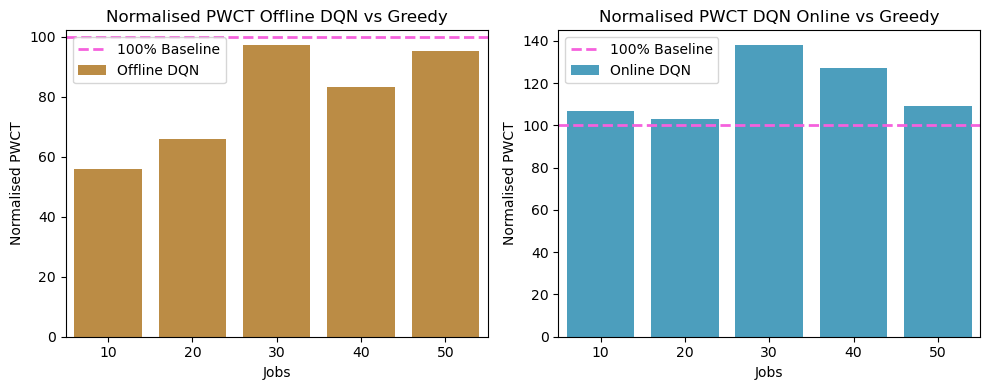

In [30]:
# Plot the result after standardising the PWCT of the Greedy agent

# Separate Greedy and DQN data
greedy_df = results_df[results_df['Agent'] == 'Greedy'].reset_index(drop=True)
dqn_online_df = results_df[results_df['Agent'] == 'Online DQN'].reset_index(drop=True)
dqn_offline_df = results_df[results_df['Agent'] == 'Offline DQN'].reset_index(drop=True)

# Normalise the DQN data
dqn_online_df['Normalised PWCT'] = (dqn_online_df['Priority Weighted Cycle Time (PWCT)'] / greedy_df['Priority Weighted Cycle Time (PWCT)']) * 100
dqn_offline_df['Normalised PWCT'] = (dqn_offline_df['Priority Weighted Cycle Time (PWCT)'] / greedy_df['Priority Weighted Cycle Time (PWCT)']) * 100

# Create a figure with two subplots
plt.figure(figsize=(10, 4)) 

# Plot 1
plt.subplot(1, 2, 2) 
sns.barplot(x='Jobs', y='Normalised PWCT', hue='Agent', data=dqn_online_df, palette={'Online DQN': '#39a7d0'})
plt.axhline(100, color='#f561dd', linestyle='--', linewidth=2, label='100% Baseline')
plt.title('Normalised PWCT DQN Online vs Greedy')
plt.legend()

# Plot 2
plt.subplot(1, 2, 1)
sns.barplot(x='Jobs', y='Normalised PWCT', hue='Agent', data=dqn_offline_df, palette={'Offline DQN': '#ce9032'})
plt.axhline(100, color='#f561dd', linestyle='--', linewidth=2, label='100% Baseline')
plt.title('Normalised PWCT Offline DQN vs Greedy')
plt.legend()


plt.tight_layout() 
plt.show()

**Figure 9**: Normalised PWCT Online/Offline DQN vs. Greedy on datasets 1-5

As seen in figure 9, the offline DQN approach yields better results compared tp the greedy agent for all datasets. Especially for small datasets with only few job instances, the offline approach yields much lower PWCT values than the greedy agent. For example, on dataset 1, the PWCT computed by the offline RL agent makes up only around 56% of the PWCT computed by greedy. The online approach on the other hand performs worse than greedy on all datasets. This might be due to limitations in our approach to optimise the algorithm. More precisely, the online DQN algorithm is computationlly costly due to a long training procedure. Hence, testing out more combinations of hyper-parameters and other network architectures such as recurrent DNN's might require devices with larger computing power. Further improving the online DQN agent might be an interesting area for future research. Additionally, we propose to investigate the performance of these algorithms on further datasets. For instance, it could be interesting to research how these algorithms perform when the ration of jobs : machines or jobs : families differs from the ones we settled on in our data sets. Lastly, similarly to Paeng, Park & Park (2021, p. 101399), both DQN algorithms require retraining, for instance when modifying the number of families, which can be computationally costly and inefficient. Hence, developing a state and action structure that is independent of the number of families might be an intriguing field for future research.

In conclusion, using DRL to approximate optimal solutions to the PMS can yield promising results. In particular, we showed that an offline DQN approach with optimised hyper-parameters is capable of producing significantly lower priority weighted cycle time compared to the baseline greedy model.

## Further Notes

In order to run the models on a local machine, these Python scripts need to be executed in the following order prior to running this Jupyter notebook:

1. 'plots.py'
2. 'environment.py'
3. 'agents.py'
4. 'tools.py'
5. 'experiments.py'

There is no need to run the two scripts, 'optimisation_offline.py' and 'optimisation_online.py', in which the hyper-parameters for the two DQN agents are optimised, as the results are saved in csv files ('results_parameters_offline.csv' and 'results_parameters_online.csv'). Nonetheless, if these results should be reproduced locally, these two notebooks should be executed before running the 'experiments.py' script. Note, however, that these two scripts contain random search algorithms with 81 iterations each and thus take quite long to execute.

If any uncertainty persists, please reach out to the authors of this project. All three authors contributed equally to the project.

## References

Kayvanfar, V., Komaki, G., Aalaei, A. & Zandieh, M. (2014). Minimizing total tardiness and earliness on unrelated parallel machines with controllable processing times. *Computers & Operations Research, 41*, 31-43. https://doi.org/10.1016/j.cor.2013.08.003

Lee, D., Kang, H., Lee, D., Lee, J., & Kim, K. (2023). Deep Reinforcement Learning-Based Scheduler on Parallel Dedicated Machine Scheduling Problem towards Minimizing Total Tardiness. *Sustainability, 15*(2920), 1-14. https://doi.org/10.3390/su15042920

Li, Z., Yang, H., Zhang, S. & Liu, G. (2016). Unrelated parallel machine scheduling problem with energy and tardiness cost. *The International Journal of Advanced Manufacturing Technology, 84*, 213–226. https://doi.org/10.1007/s00170-015-7657-2

Mokotoff, E. (2001). Parallel machine scheduling problems: A survey. *Asia - Pacific Journal of Operational Research, 18*(2), 193-242. https://www.proquest.com/scholarly-journals/parallel-machine-scheduling-problems-survey/docview/204764435/se-2

Paeng, B., Park, I. & Park, J. (2021). Deep Reinforcement Learning for Minimizing Tardiness in Parallel Machine Scheduling With Sequence Dependent Family Setups. *IEEE Access, 9*, 101390 - 101401. https://doi.org/10.1109/ACCESS.2021.3097254

Sutton, R., & Barto, A. (2014). *Reinforcement Learning: An Introduction* (2nd ed.). Cam- bridge, Massachusetts: MIT Press.

Yang, D. & Yang, S. (2013). Unrelated parallel-machine scheduling problems with multiple rate-modifying activities. *Information Sciences, 235*, 280-286. https://doi.org/10.1016/j.ins.2013.02.013